# End-to-End Content-Based Message Spam Detection

  In this project, we built, trained, and evaluated a model that classifies text messages as spam or ham based on the message's content. The term *ham* designates a message that is generally legitimate and is not considered spam.

  The model is built using the Multinomial Naive Bayes (MNB) classifier. It is a fast algorithm that is suited for text classification.

  This notebook is divided into six sections:
1.   Loading the labeled SMS dataset. 
2.   Visualizing the data.
3.   Applying natural language processing (NLP) to the textual data.
4.   Extracting numerical features from the textual data using Term Frequency - Inverse Document Frequency (TF-IDF).
5.   Building, training, and evaluating the model.
6.   Conclusions.

### Prerequisites

We used [Python 3](https://www.python.org/) and the following libraries: 

* [Pandas](https://pandas.pydata.org/docs/index.html#): data structures and analysis for python.
* [Matplotlib](https://matplotlib.org/): Python plotting library.
* [Wordcloud](https://pypi.org/project/wordcloud/): word cloud generator in Python.
* [NLTK](https://www.nltk.org/): natural language processing.
* [Scikit-learn](scikit-learn.org): machine learning.

In [1]:
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

# Regular Expressions
import re 

from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import  MultinomialNB
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay

# Pickel: serializing and de-serializing Python object structures. 
# It is used here to save our trained machine learning models to disk for future use.
import pickle

# Display multiple Variables in the same cell without print() statements
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## 1. Loading the labeled SMS dataset

  The dataset used in this project is the SMS Spam Collection dataset. It is a public set of SMS labeled messages that have been collected for mobile phone spam research. 
  
  It is hosted in the machine learning repository of the UCL Center of Machine Learning and Intelligent systems https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection. It is stored there in a single text file, but also available in a CSV file at https://www.kaggle.com/uciml/sms-spam-collection-dataset.

### 1.1. Loading the dataset into a Pandas dataframe

  We loaded the dataset into a Pandas dataframe and dropped unneeded columns and duplicated rows. 


In [2]:
df = pd.read_csv('data/spam.csv', encoding = 'latin-1')

df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


### 1.2. Dropping unneeded columns

  The resulting datafarme has two columns: 'text' for the text messages and 'class' for their label (spam or ham).

In [3]:
df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis = 1, inplace = True)

df.rename(columns = {'v1': 'class', 'v2': 'text'}, inplace = True)

df.head()

,class,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### 1.3. Dropping duplicated lines

In [4]:
df.describe()
df.drop_duplicates(inplace = True, ignore_index = True)
df.count()

,class,text
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


class    5169
text     5169
dtype: int64

## 2. Data visualization
### 2.1. Plotting charts that show the numbers and proportions of spam and ham messages 

*   The plots show that we have an imbalanced dataset with a disproportionate ratio of observations in each class. 
*   To handle imbalanced datasets, a number of techniques can be used. They include up-scaling the minority class, down-scaling the majority class, and using performance metrics and classification algorithms that are suitable for imbalanced datasets. 
*   In this project, we did not re-scale the different classes. However, we used the performance metrics, F1-score and confusion matrix, which are suited for imbalanced datasets. The trained model achieves a good performance for the scope of this project, without a need for re-scaling.  

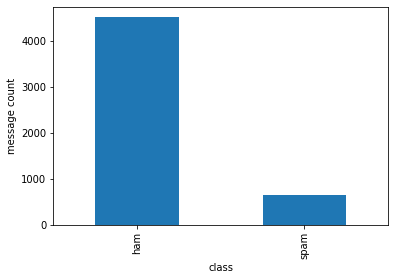

In [5]:
df['class'].value_counts().plot(kind = 'bar', xlabel = 'class', ylabel = 'message count');


Proportion of spam messages: 12.63%


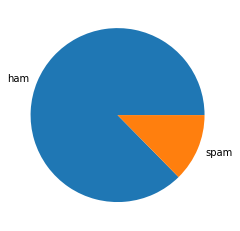

In [6]:
print('\nProportion of spam messages: {:.02f}%'.format(df['class'].value_counts().values[1] * 100 / df['class'].count()))

df['class'].value_counts().plot(kind = 'pie',ylabel = '', xlabel = '', title = '');

### 2.2. Displaying word clouds for the different classes
  It is not surprising to see some of the most common words in messages that are labeled as spam: **free, claim, prize.**

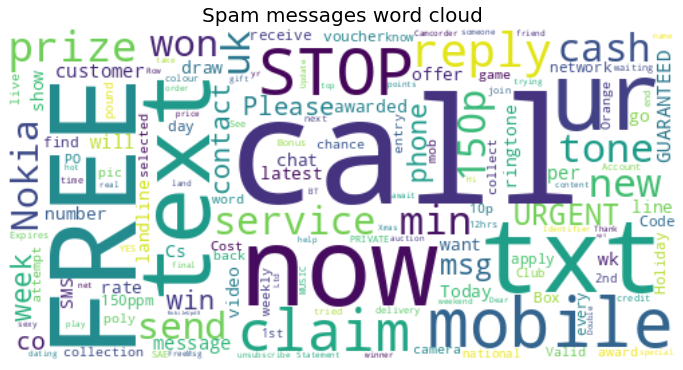

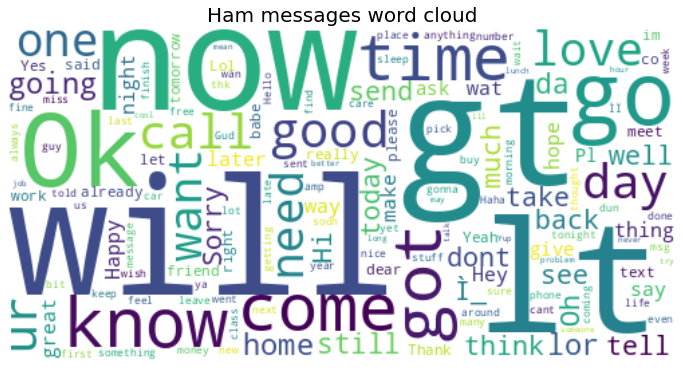

In [17]:
spam_words = ' '.join(df[df['class'] == 'spam']['text'])
ham_words = ' '.join(df[df['class'] == 'ham']['text'])

wordcloud_spam = WordCloud(background_color = "white", max_words = 150, width = 500, \
                           height = 250, min_word_length = 2, collocations = False) \
                           .generate(spam_words)

wordcloud_ham = WordCloud(background_color = "white", max_words = 150, width = 500, \
                          height = 250, min_word_length = 2, collocations = False) \
                          .generate(ham_words)

# wordcloud_spam.to_file("media/wordcloud_spam.png");
# wordcloud_ham.to_file("media/wordcloud_ham.png");

plt.figure(figsize=(12,12), frameon=True)
plt.imshow(wordcloud_spam, interpolation="bilinear")  
plt.axis('off')
plt.title('Spam messages word cloud', fontsize=20)
plt.show()

plt.figure(figsize=(12,12), frameon=True)
plt.imshow(wordcloud_ham, interpolation="bilinear")
plt.axis("off")
plt.title('Ham messages word cloud', fontsize=20)
plt.show();

## 3. Preprocessing

### 3.1. Converting class labels to numerical form 

  Since they are represented by a binary variable ('spam', 'ham'), we converted them in a new column to '1' for 'spam' and '0' for 'ham'.

In [8]:
df['class_num'] = df['class'].apply(lambda x: 1 if x == 'spam' else 0)

df.head()
df.groupby(['class_num']).count()

,class,text,class_num
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


,class,text
class_num,,
0,4516,4516
1,653,653


### 3.2. Natural language processing

  In the next cell, we wrote a simple text preprocessing function that does the following:
*   Lower case mapping: All words are mapped to their lowercase form. {'DATA', 'data'} --> 'data'.
*   Removing one-letter words, special characters, and stop-words: stop-words are common (English) words that do not contribute much to the content or meaning of a document (e.g., "the", "a", "is", "to", etc.). 
*   Stemming: It means mapping different forms of the same word to a common base form or 'stem'. It basically means chopping off the ends of words and only keeping their base form.

  Text preprocessing is a big topic in NLP and is task-dependent. It should be done carefully since ignoring it may lead to inconsistent classification results and overdoing it can strip the raw data from meaningful information that may be useful to the classifier.  
  We used the Natural Language Toolkit (NLTK) for stop-word removal and stemming.

In [9]:
nltk.download('stopwords', quiet=True)
nltk.download('snowball_data', quiet=True)

stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")

def  preprocessing(message, stemmer):
    split_regex = '[^a-zA-Z0-9,]+'
    message_out = ''
    for word in re.split(split_regex, message):
        word = word.lower()
        word = re.sub(',', '', word)
        if (word not in stop_words)  and (len(word) != 1):
            message_out = ' '.join([message_out, stemmer.stem(word)])
    return message_out

df['processed_text'] =  df['text'].apply(lambda x: preprocessing(x, stemmer))

df.sample(5)


True

True

,class,text,class_num,processed_text
1091,ham,Hey... What time is your driving on fri? We go...,0,hey time drive fri go evalu fri
1601,spam,For ur chance to win a å£250 cash every wk TXT...,1,ur chanc win 250 cash everi wk txt action 806...
2782,ham,Are you coming to day for class.,0,come day class
4712,ham,Hey next sun 1030 there's a basic yoga course....,0,hey next sun 1030 basic yoga cours bugi go pi...
191,ham,It will stop on itself. I however suggest she ...,0,stop howev suggest stay someon abl give or ev...


## 4. Feature Extraction 

  This section tackles the issue of extracting numerical features from the preprocessed text messages. These numerical features are used to feed our machine learning algorithm. 

### 4.1. Bag of Words

  A basic metric that come to mind is word count; the significance of a word can be measured by the frequency of its occurrence in a dataset or a data sample.

  In the following cell, We used the NLTK word tokenizer to split the preprocessed text messages into separate words, which are collected in what is usually called a bag of words.  One bag of words is used for the words occurring in messages labeled 'spam'. The other one for those occurring in messages labeled 'ham'. Then, we displayed:

*   The number of unique words in both bags of words.
*   Line plots of the frequency of the 20 most common words in ham-labeled and spam-labeled messages.

  Two observations:

*   As we have seen in the word clouds we looked at above, some of the words that are common in spam-labeled messages do not appear as frequently in ham-labeled messages and vice-versa. 
*   The token 'ur' appears as one of the most frequent words in both bags of words. It is a slang of 'your' that appears often in text messages. The token 'your' was filtered during preprocessing as one of the stop-words, but 'ur' wasn't. This is one of the situations were the stop-words list may have to be adjusted during data preprocessing. In this study, did not redo preprocessing, but this is something to be mindful of.


The number of words in the ham bag of words:  5573

The number of words in the spam bag of words:  2535 



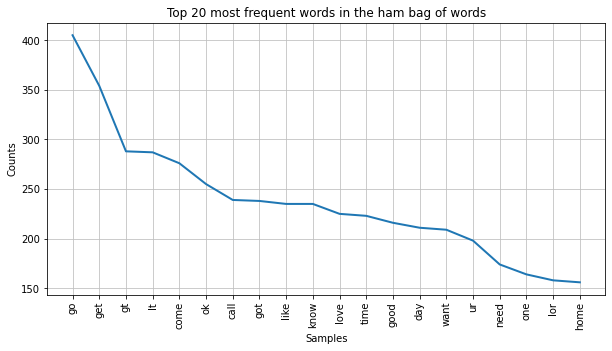

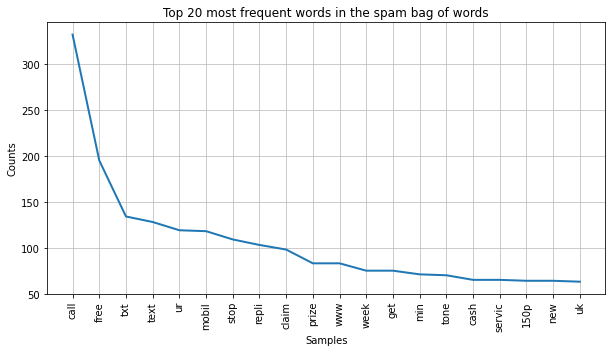

In [10]:
bag_spam = []
bag_ham = []
for index, row in df.iterrows():
    if row['class_num'] == 1:
        bag_spam.extend(word_tokenize(row['processed_text']))
    elif row['class_num'] == 0:
        bag_ham.extend(word_tokenize(row['processed_text']))

bag_ham = nltk.FreqDist(bag_ham) 
bag_spam = nltk.FreqDist(bag_spam) 

print('\nThe number of words in the ham bag of words: ', len(bag_ham))
print('\nThe number of words in the spam bag of words: ', len(bag_spam), '\n')

plt.figure(figsize=(10,5), frameon=True)
bag_ham.plot(20, title = 'Top 20 most frequent words in the ham bag of words');
plt.figure(figsize=(10,5), frameon=True)
bag_spam.plot(20, title = 'Top 20 most frequent words in the spam bag of words');

### 4.2. Feature Extraction using TF-IDF

  Instead of simply looking at the words frequencies, we used **'Term Frequency - Inverse Document Frequency' (TF-IDF)**, which is a good heuristic that assigns weights to each word based on its importance.

*   **Term Frequency (TF)** rewards words that appear many times in the same document. It is computed as the frequency of a word in a text message. If a word occurs often in the message, then it is more important to the meaning of the message.
*   **Inverse Document frequency (IDF)** rewards words that are rare overall in a dataset. The intuition is that two messages are more likely to belong to the same class if they share a rare word than a common one. 

*   The **TF-IDF** weight for a word in a message is the product of its TF and IDF weights.

  We used the sparse TF-IDF vectorizer from Scikit learn to extract the features from our preprocessed text messages. Before this, we split the dataset into training, validation, and testing datasets.

  We used a 80%, 20%, 20% split for the training, validation, and testing sets, respectively. We also mad sure that we have a proportional number of 'spam' and 'ham' messages in the different sets. 

In [11]:
# We first split the dataset into a testing set and a training and validaton set.

x_train_validate, x_test, y_train_validate, y_test = train_test_split(df['processed_text'], df['class_num'], test_size = 0.20, stratify = df['class_num'], random_state = 42)


# We then split the training and validation set into a training set and a validation set.

x_train, x_validate, y_train, y_validate = train_test_split(x_train_validate, y_train_validate, test_size = 0.25, stratify = y_train_validate, random_state = 42)

print('\nThe training, validation, and testing sets contain {0}, {1}, and {2} messages, respectively.\n'.format(len(x_train), len(x_validate), len(x_test)))

print('\nNumber of ham (0) and spam (1) messages in the training set:\n')
y_train.value_counts()
print('\nNumber of ham (0) and spam (1) messages in the validation set:\n')
y_validate.value_counts()
print('\nNumber of ham (0) and spam (1) messages in the testing set:\n')
y_test.value_counts()


The training, validation, and testing sets contain 3101, 1034, and 1034 messages, respectively.


Number of ham (0) and spam (1) messages in the training set:



0    2710
1     391
Name: class_num, dtype: int64


Number of ham (0) and spam (1) messages in the validation set:



0    903
1    131
Name: class_num, dtype: int64


Number of ham (0) and spam (1) messages in the testing set:



0    903
1    131
Name: class_num, dtype: int64

In [12]:
#Feature Extraction.
# TF-IDF is a weighted bag of words technique that assigns weigths to each token (e.g., word) based on its importance.
 
vectorizer = TfidfVectorizer() 

vectorizer.fit(x_train_validate);

# Extracting features from the training, validation, and testing test data using the same vectorizer:
x_train_tfidf_vec =  vectorizer.transform(x_train)
x_validate_tfidf_vec =  vectorizer.transform(x_validate)
x_test_tfidf_vec =  vectorizer.transform(x_test)

x_train_validate_tfidf_vec = vectorizer.transform(x_train_validate)

type(x_train_tfidf_vec)
print('\nThe TF-IDF sparse vector for the training dataset has {} samples and {} features.\n'.format(x_train_tfidf_vec.shape[0], x_train_tfidf_vec.shape[1]))

TfidfVectorizer()

scipy.sparse.csr.csr_matrix


The TF-IDF sparse vector for the training dataset has 3101 samples and 6327 features.



## 5. Training and Evaluating the Classifier

  The classification algorithm used here is the multinomial naive Bayes (MNB) algorithm. It is a fast algorthitm that is suited for text classification. 'MultinomialNB' is the SciKit Learn implementation of this algorithm. You can read more about it at https://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes.

  Hyperparameter tuning:

*    **alpha** (default aplha = 1): additive smoothing hyperparameter. alpha = 0 corresponds to no smoothing.

  We performed grid search to tune the hyperparameter alpha. For multiple values of alpha, we trained the 'MultinomialNB' classifier on the training dataset and validated it using the validation dataset. The aim is to find the model that achieves the highest F1-score.


  After fine tuning the hyperparameters, we evaluated our model on the test dataset. Note that the test dataset was not used at any stage of the model building process.

### 5.1. Model training and hyperparameter tuning

In [13]:
%%time
model_name = MultinomialNB

# Grid search:

alpha = [1e-8, 1e-6, 1e-4, 1e-5, 1e-2, 1e-1, 2e-1, 3e-1, 4e-1, 5e-1, 6e-1, 7e-1, 8e-1, 9e-1, 1]

higest_f1_Score = 0
best_alpha = 1

for al in alpha:
    model = model_name(alpha = al)
    model.fit(x_train_tfidf_vec, y_train);
    pred = model.predict(x_validate_tfidf_vec)
    score = f1_score(y_validate, pred)
    if score > higest_f1_Score:
        higest_f1_Score = score
        best_alpha = al

print('\nBest additive smoothing parameter alpha =', best_alpha)

# Fitting the model using the best value of alpha.

best_model = model_name(alpha = best_alpha)
best_model.fit(x_train_validate_tfidf_vec, y_train_validate);


Best additive smoothing parameter alpha = 0.01
CPU times: user 42 ms, sys: 0 ns, total: 42 ms
Wall time: 40.7 ms


MultinomialNB(alpha=0.01)

### 5.2. Model testing
  We finally use our our trained model to predict the classes of the messages in the test dataset and calculate the performance metrics. 


Evaluating the model on the test dataset:

F1 Score: 0.92

Confusion Matrix:



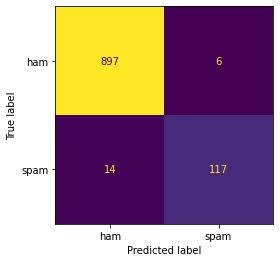

In [14]:
print('\nEvaluating the model on the test dataset:')
pred = best_model.predict(x_test_tfidf_vec)
cm = confusion_matrix(y_test, pred, labels = best_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['ham','spam'])
print('\nF1 Score: {:.2f}\n'.format(f1_score(y_test, pred)))
print('Confusion Matrix:\n')
disp.plot(colorbar = False);

### 5.3. Implementing a function that classifies a single text message
  We were working on a dataset of labeled messages. Let us suppose we want to test our model on a single text message. The function we wrote below can do just that.  

In [15]:
def Is_it_spam(message):
    processed_message = [preprocessing(message, stemmer),]
    x_vec =  vectorizer.transform(processed_message)
    pred = best_model.predict(x_vec)
    if pred.tolist()[0] == 1:
        print('The message: \"{}\" is spam'.format(message))
    else: 
        print('The message: \"{}\" is not spam'.format(message))

Is_it_spam('URGENT: pleset text 5585585558 now to claim your prize: Free car')
Is_it_spam('I will be coming tomorrow. See you!')
Is_it_spam('FREE: You have been selected as one of the lucky winners. reply YES to continue')

The message: "URGENT: pleset text 5585585558 now to claim your prize: Free car" is spam
The message: "I will be coming tomorrow. See you!" is not spam
The message: "FREE: You have been selected as one of the lucky winners. reply YES to continue" is spam


### 5.4. Saving the victorizer and classification model to disk for future use

In [16]:
pickle.dump(vectorizer, open("models/tfidf_victorizer_spam_dataset1.pkl","wb"))
pickle.dump(best_model, open("models/MultinomialNB_spam_classifier1.pkl","wb"))

## 6. Conclusions

  In this notebook, we showed the different stages of a machine learning workflow starting from loading, cleaning, and visualizing the data to building, training, tuning, and testing a machine learning model. We applied these stages to spam classification and achieved a good F1 score of 0.92. 

  The classification results may be improved by considering other classification algorithms, refining text preprocessing, and using K-fold cross-validation. In the latter, the training and validation dataset is divided into k subsets, and grid search for hyperparameter tuning is repeated k times. Each time, one of the k subsets is used as the validation set and the other k-1 subsets are merged and used as a training set. The evaluation is done using the average F1 score across the k runs.